In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from tqdm import tqdm
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import torchvision

In [1]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [3]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

In [5]:
def get_transform():
    transform = transforms.Compose([transforms.ToTensor()])
    return transform

In [16]:
def load_mnist_data(image_path = "data/"):
    mnist_dataset = torchvision.datasets.MNIST(root=image_path, train=True, transform=get_transform(), download=True)
    mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
    mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
    mnist_test_dataset = torchvision.datasets.MNIST(root=image_path, train=False, transform=get_transform(), download=False)

    return mnist_train_dataset, mnist_valid_dataset, mnist_test_dataset

In [17]:
mnist_train_dataset, mnist_valid_dataset, mnist_test_dataset = load_mnist_data()
len(mnist_train_dataset), len(mnist_valid_dataset), len(mnist_test_dataset)

(50000, 10000, 10000)

In [18]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # (1 * 28 * 28)

        # 블록1(conv1 + pool1)
        # (32, 28, 28)
        # (32, 14, 14)

        # 블록2(conv2 + pool2)
        # (64, 14, 14)
        # (64, 7, 7)
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # Fully
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3136,1024)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1024,num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu3(self.fc1(x)))
        x = self.fc2(x)
        return x

In [19]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=10,
    device="cpu",
):
    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0

        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            predictions = model(images)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(predictions.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            train_pbar.set_postfix(
                {"loss": f"{loss.item():.4f}", "acc": f"{100 * correct / total:.2f}%"}
            )

        avg_loss = epoch_loss / len(train_loader)
        accuracy = 100 * correct / total
        train_loss_history.append(avg_loss)
        train_accuracy_history.append(accuracy)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                val_pbar.set_postfix(
                    {
                        "loss": f"{loss.item():.4f}",
                        "acc": f"{100 * val_correct / val_total:.2f}%",
                    }
                )

        val_avg_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_loss_history.append(val_avg_loss)
        val_accuracy_history.append(val_accuracy)

        # 학습률 스케줄러 업데이트
        scheduler.step()

        print(
            f"Epoch [{epoch+1}/{num_epochs}], "
            f"Train Loss: {avg_loss:.4f}, Train Acc: {accuracy:.2f}%, "
            f"Val Loss: {val_avg_loss:.4f}, Val Acc: {val_accuracy:.2f}%"
        )

    return (
        train_loss_history,
        train_accuracy_history,
        val_loss_history,
        val_accuracy_history,
    )

In [20]:
def evaluate_model(model, test_loader, device="cpu"):
    model.eval()
    predictions = []
    actuals = []
    correct = 0
    total = 0
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        val_pbar = tqdm(test_loader, desc="[Val]")
        for images, labels in val_pbar:
            images, labels = images.to(device), labels.to(device)
            pred = model(images)
            loss = criterion(pred, labels)

            _, predicted = torch.max(pred.data, 1)
            predictions.extend(predicted.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_loss += loss.item()

            val_pbar.set_postfix(
                {"loss": f"{loss.item():.4f}", "acc": f"{100 * correct / total:.2f}%"}
            )

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    print(f"\n=== 검증 세트 평가 ===")
    print(f"Loss: {avg_loss:.4f}")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Correct: {correct}/{total}")

    return predictions, actuals, accuracy, avg_loss

In [21]:
def plot_learning_curve(
    loss_history,
    accuracy_history,
    val_loss_history=None,
    val_accuracy_history=None,
    title="Training Progress",
):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(loss_history, linewidth=2, color="#2E86AB", label="Train Loss")
    if val_loss_history:
        ax1.plot(val_loss_history, linewidth=2, color="#A23B72", label="Val Loss")
    ax1.set_title("Training Loss", fontsize=14, fontweight="bold")
    ax1.set_xlabel("Epoch", fontsize=12)
    ax1.set_ylabel("Loss", fontsize=12)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(accuracy_history, linewidth=2, color="#2E86AB", label="Train Acc")
    if val_accuracy_history:
        ax2.plot(val_accuracy_history, linewidth=2, color="#A23B72", label="Val Acc")
    ax2.set_title("Training Accuracy", fontsize=14, fontweight="bold")
    ax2.set_xlabel("Epoch", fontsize=12)
    ax2.set_ylabel("Accuracy (%)", fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [22]:
num_epochs = 3 # 반복 
batch_size = 64 # 학습크기

torch.manual_seed(42) # 재현성을 위한 랜덤 값
np.random.seed(42) # 재현성을 위한 랜덤 값

device = get_device() # 계산 장치 설정
print(f"{device}를 사용합니다.")

mnist_train_dataset, mnist_valid_dataset, mnist_test_dataset = load_mnist_data()
train_loader = DataLoader(mnist_train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(mnist_valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test_dataset, batch_size=batch_size, shuffle=True)

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history = train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=num_epochs, device=device)

cpu를 사용합니다.


Epoch 1/3 [Val]: 100%|██████████| 157/157 [00:02<00:00, 60.46it/s, loss=0.0029, acc=98.25%]


Epoch [1/3], Train Loss: 0.1620, Train Acc: 95.01%, Val Loss: 0.0556, Val Acc: 98.25%


Epoch 2/3 [Val]: 100%|██████████| 157/157 [00:03<00:00, 50.31it/s, loss=0.0109, acc=98.65%]


Epoch [2/3], Train Loss: 0.0481, Train Acc: 98.49%, Val Loss: 0.0458, Val Acc: 98.65%


Epoch 3/3 [Val]: 100%|██████████| 157/157 [00:02<00:00, 56.18it/s, loss=0.0242, acc=98.78%]

Epoch [3/3], Train Loss: 0.0331, Train Acc: 98.97%, Val Loss: 0.0415, Val Acc: 98.78%


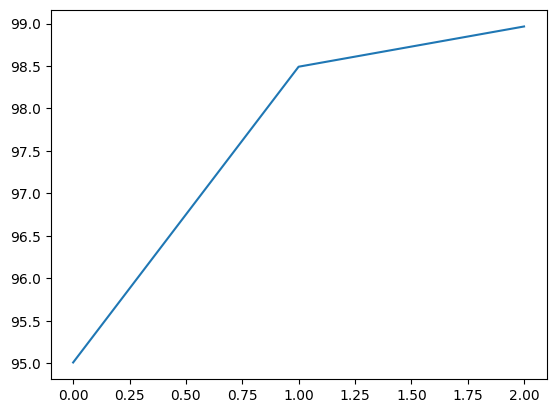

In [24]:
plt.plot(train_accuracy_history)

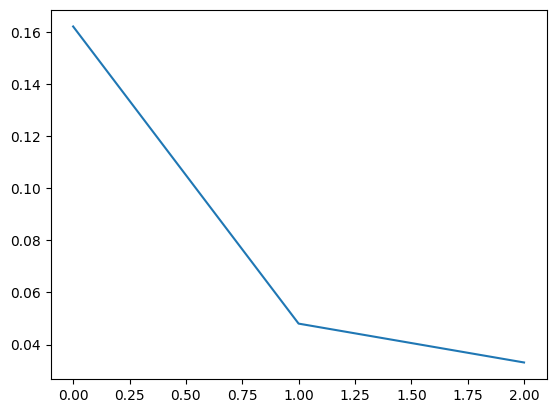

In [25]:
plt.plot(train_loss_history)

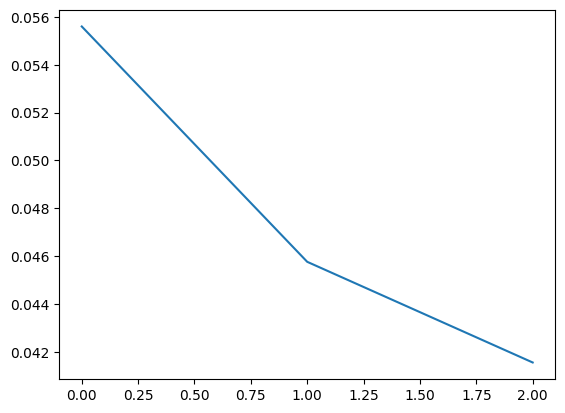

In [26]:
plt.plot(val_loss_history)

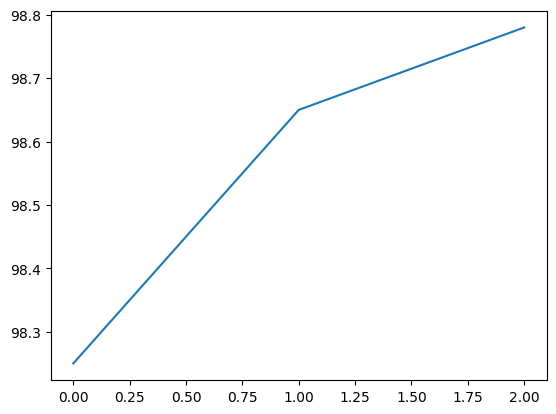

In [27]:
plt.plot(val_accuracy_history)